In [3]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [4]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [5]:
NUM_CLASSES = 26

# Dataset reading

In [6]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [7]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [10]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 512)               22016     
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 26)                6682      
                                                                 
Total params: 160,026
Trainable params: 160,026
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)

In [12]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [13]:
model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback]
)

Epoch 1/100
49/50 [============================>.] - ETA: 0s - loss: 2.8114 - accuracy: 0.1926
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
50/50 [==============================] - 5s 36ms/step - loss: 2.8077 - accuracy: 0.1934 - val_loss: 2.0898 - val_accuracy: 0.4152
Epoch 2/100
49/50 [============================>.] - ETA: 0s - loss: 2.0656 - accuracy: 0.3543
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
50/50 [==============================] - 1s 17ms/step - loss: 2.0649 - accuracy: 0.3542 - val_loss: 1.4355 - val_accuracy: 0.6062
Epoch 3/100
48/50 [===========================>..] - ETA: 0s - loss: 1.7488 - accuracy: 0.4484
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
50/50 [==============================] - 1s 17ms/step - loss: 1.7492 - accuracy: 0.4462 - val_loss: 1.1201 - val_accuracy: 0.7502
Epoch 4/100
46/50 [==========================>...] - ETA: 0s - loss: 1.5529 - accuracy: 0.4932
Ep

In [14]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

17/17 [==============================] - 0s 7ms/step - loss: 0.1757 - accuracy: 0.9374


In [15]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [16]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 1s 612ms/step
[7.5115272e-06 5.1000425e-06 4.4092762e-06 1.7822421e-01 3.3663395e-07
 9.6308248e-12 1.7525072e-03 2.8349221e-04 1.4570419e-07 2.0968794e-06
 2.9392808e-05 6.7615551e-03 6.4273277e-06 1.1093253e-05 5.1819917e-08
 2.3186256e-05 2.9351770e-05 9.0162398e-04 2.1677817e-05 2.0402011e-02
 4.2862399e-04 2.4096492e-04 1.6450302e-05 6.4796197e-01 1.0258681e-09
 1.4288571e-01]
23


# Confusion matrix

66/66 [==============================] - 1s 5ms/step


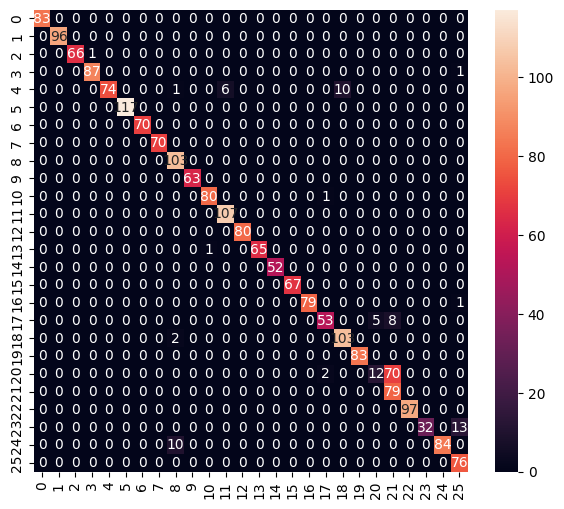

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        83
           1       1.00      1.00      1.00        96
           2       1.00      0.99      0.99        67
           3       0.99      0.99      0.99        88
           4       1.00      0.81      0.90        91
           5       1.00      1.00      1.00       117
           6       1.00      1.00      1.00        70
           7       1.00      1.00      1.00        70
           8       0.89      1.00      0.94       103
           9       1.00      1.00      1.00        63
          10       0.99      0.99      0.99        81
          11       0.95      1.00      0.97       107
          12       1.00      1.00      1.00        80
          13       1.00      0.98      0.99        66
          14       1.00      1.00      1.00        52
          15       1.00      1.00      1.00        67
          16       1.00      0.99      0.99        80
     

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [19]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [20]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Alfian\AppData\Local\Temp\tmpsch6qo2j\assets


INFO:tensorflow:Assets written to: C:\Users\Alfian\AppData\Local\Temp\tmpsch6qo2j\assets


164672

# Inference test

In [21]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [22]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [23]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [24]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 229 ms


In [25]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[6.4512956e-06 5.3238336e-06 3.9409433e-06 1.6985038e-01 3.2388746e-07
 8.8567504e-12 1.7313688e-03 2.6396883e-04 1.2774075e-07 1.9642137e-06
 2.5742773e-05 5.9225373e-03 6.6648031e-06 9.8905939e-06 4.8059182e-08
 2.1807451e-05 2.6286953e-05 8.9123443e-04 2.1087339e-05 2.0601353e-02
 4.2675569e-04 2.3290074e-04 1.8692310e-05 6.5978283e-01 8.4433815e-10
 1.4014843e-01]
23
